In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm

import statsmodels.formula.api as smf
import plotly.express as px
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_rows', 17544) 
%matplotlib inline


# Configuring plotting visual and sizes
#sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [2]:
d = pd.read_csv('/Users/sreevathsadb/Masters/Project/Data/Bike_Trips_2013_2018.csv')

In [3]:
trip_df = d.groupby(['year','month','day','hour','minute'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
trip_df.head(5)
trip_df['transformed_interactions'] = (trip_df['interactions'] + abs(trip_df['bike_arr_dep']) - trip_df['rebalance'])
active_stations_df = d.groupby(['year','month','day','hour','minute'])['interactions'].count().reset_index(name ='active_stations')

In [4]:
df_iam = pd.merge(trip_df, active_stations_df, on = ['year','month','day','hour','minute'], how = 'inner')
df_iam = df_iam[['transformed_interactions','interactions','active_stations']]
df_iam['active_stations_sq'] = df_iam['active_stations'] * df_iam['active_stations']
df_iam.sample(5)

,transformed_interactions,interactions,active_stations,active_stations_sq
175715,68.0,55.0,40,1600
87975,4.0,2.0,2,4
145164,56.0,40.0,29,841
42107,70.0,61.0,34,1156
143221,206.0,152.0,63,3969


### IAM Basic Model

For the interval aggregation model (IAM) we modify Eq. (20) to use the D temporal resolution data to estimate the number of interactions rather than daily trips. IAM sums interactions across all station in the BSS for each interval duration. The BSS normalization variable AzDdt from Eq. (15) is included as well as it’s square to compensate for interaction collision losses.

## Assumptions for Linear Regression

### Linearity

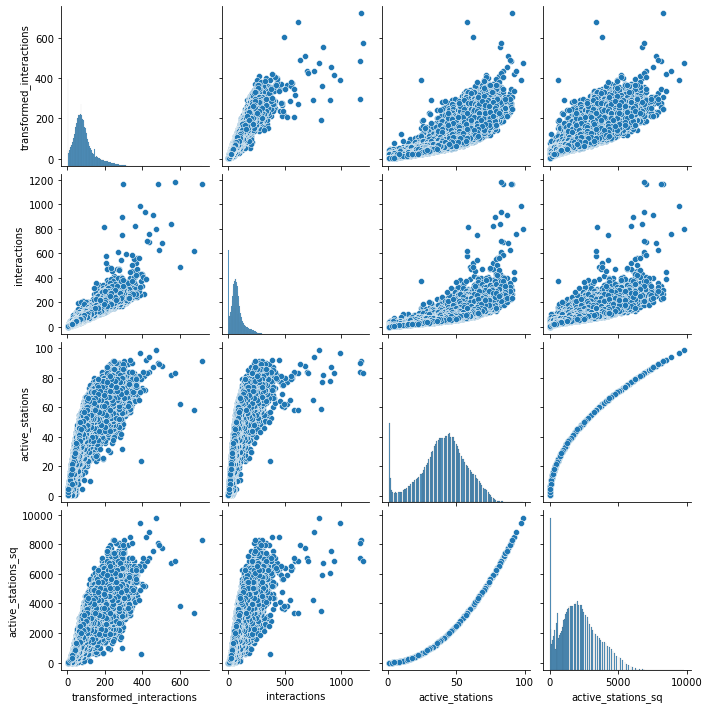

In [5]:
### Pairs Plot
p = sns.pairplot(df_iam)

From the above plot we can see that there is a non-linear relationship between tranformed_interactions and the interactions. So the Linearity assumption is not satisfied.

### Training and Testing IAM Model

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(df_iam,df_iam, test_size = 0.3,random_state=0)
cdam_model = smf.ols(formula='transformed_interactions ~ 0 + interactions + active_stations + active_stations_sq', data=xtrain).fit()
y_pred = cdam_model.predict(xtest)
print(cdam_model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     transformed_interactions   R-squared (uncentered):                   0.978
Model:                                  OLS   Adj. R-squared (uncentered):              0.978
Method:                       Least Squares   F-statistic:                          1.928e+06
Date:                      Tue, 26 Jul 2022   Prob (F-statistic):                        0.00
Time:                              15:47:11   Log-Likelihood:                     -5.3879e+05
No. Observations:                    130339   AIC:                                  1.078e+06
Df Residuals:                        130336   BIC:                                  1.078e+06
Df Model:                                 3                                                  
Covariance Type:                  nonrobust                                                  
                         coef    std err          t      P>|

### Mean of Residuals
Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero. So let's find out.

In [7]:
residuals = xtest['transformed_interactions']-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))
print("NRMSE {}".format(np.sqrt(mean_squared_error(xtest['transformed_interactions'], y_pred))/(xtest['transformed_interactions'].mean())))



Mean of Residuals 0.08922462267120752
NRMSE 0.17267743893797277


In [8]:
residuals.describe()

count    55860.000000
mean         0.089225
std         14.814228
min       -492.410532
25%         -6.647060
50%         -0.726282
75%          5.249589
max        167.343728
dtype: float64

### Detecting heteroscedasticity!

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms.

In [9]:
y_pred.describe()

count    55860.000000
mean        85.702899
std         53.637377
min          1.180962
25%         51.217721
50%         77.714570
75%        108.877453
max        785.410532
dtype: float64

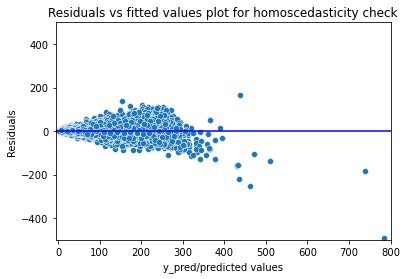

In [10]:
p = sns.scatterplot(y_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-500,500)
plt.xlim(-6,800)
p = sns.lineplot([-60,6000],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.

Null Hypothesis: Error terms are homoscedastic.

Alternative Hypothesis: Error terms are heteroscedastic.

In [11]:
X_train =  xtest.drop(["transformed_interactions"],axis=1)
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.067851104035813), ('p-value', 2.0693824079471374e-08)]

Since p value is less than 0.05 in Goldfeld Quandt Test, we reject the null hypothesis that error terms are heteroscedastic. So this assumption is failed.

### Check for Normality of error terms/residuals

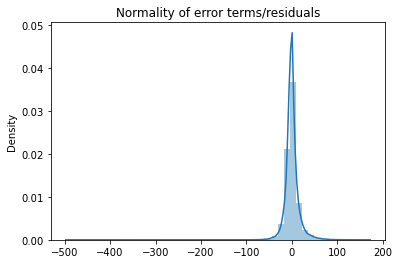

In [12]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

The residual terms are pretty much normally distributed for the number of test points we took. Remember the central limit theorem which says that as the sample size increases the distribution tends to be normal. A skew is also visible from the plot. It's very difficult to get perfect curves, distributions in real life data.

### Autocorrelation of residuals

When the residuals are autocorrelated, it means that the current value is dependent of the previous (historic) values and that there is a definite unexplained pattern in the Y variable that shows up in the error terms. Though it is more evident in time series data.

Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.

Null Hypothesis: Autocorrelation is absent.

Alternative Hypothesis: Autocorrelation is present.

In [13]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.07467984717414049

Since p value is greater than 0.05 we fail reject null hypothesis. Hence Auto Correlation is not  present.

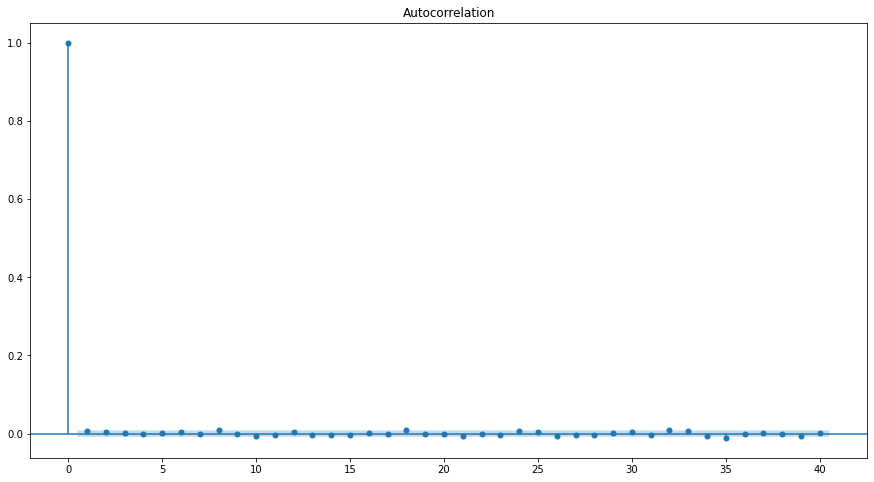

In [27]:
plt.rcParams["figure.figsize"] = (15,8)
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

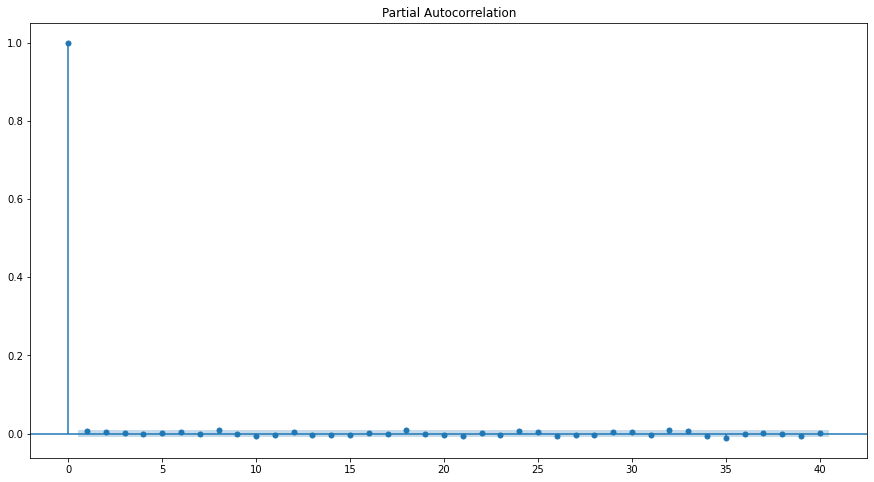

In [28]:
plt.rcParams["figure.figsize"] = (15,8)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

There results doesn't show any auto correlation, as we couldnt see any spikes outsided the blue confidence interval region.

Reference : https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression/notebook